In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
from utils import ScatteringProblem


In [173]:
# this parameters work when I/100
filename_out    = 'output/inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1e-2
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 100

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x     = 10
ndim_pad_x = 522

ndim_y     = 512
ndim_z     = 10
ndim_pad_zy = 10 


# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x + ndim_pad_x 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False


lambd_fit_forw         = 10 
lambd_mmd_forw         = 100
lambd_reconstruct      = 1.
lambd_mmd_back         = 100

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

#mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_forw_kernels = [(0.2, 1), (1.5, 1), (3.0, 1)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 2
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblem( device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, lambd_mmd_forw, lambd_mmd_back, lambd_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [174]:
lp.update_hyperparameters( device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, lambd_mmd_forw, lambd_mmd_back, lambd_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [175]:
lp.create_loaders()

In [176]:
def subnet(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input = Ff.InputNode(ndim_x + ndim_pad_x, name='input')


nodes = [input]
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)

In [177]:
lp.set_model(model)
lp.set_optimizer()

In [178]:
lp.train()

Epoch            L_fit       L_mmd_fwd      L_mmd_back       L_reconst     L_fit(test) L_mmd_fwd(test) L_mmd_back(test) L_reconst(test)
   000         10.6609          0.7302          0.9333          7.3404         10.4979          0.6776          0.9338          5.0886
   001         10.3388          0.6785          0.9339          5.6323         10.2905          0.6789          0.9338          5.3918
   002         10.2721          0.6784          0.9338          5.8109         10.1124          0.6779          0.9338          4.8825
   003         10.0580          0.6780          0.9338          4.8275         10.1885          0.6779          0.9337          4.6017
   004         10.5022          0.6796          0.9338          5.0847         10.6190          0.6800          0.9339          4.6095
   005         10.4903          0.6786          0.9342          6.5892         10.4880          0.6782          0.9342          6.9482
   006         10.5198          0.6780          0.9341

In [179]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

In [180]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes

Accuracy is 36.07%
MSE for radius per shape for correctly identified instances as follows: sphere: 1461426228.7240, hardsphere: 2958864.9448 and cylinder: 802175269250253824.0000
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 545560.0250, hardsphere: 39.6871 and cylinder: 573814619377352.5000
MSE for cylinder length for correctly identified instances: 37613593576075295752978432.0000
MSE for cylinder length polydispersity for correctly identified instances: 13469021241394802688.0000
MSE for cylinder length for correctly identified instances: 38.0160


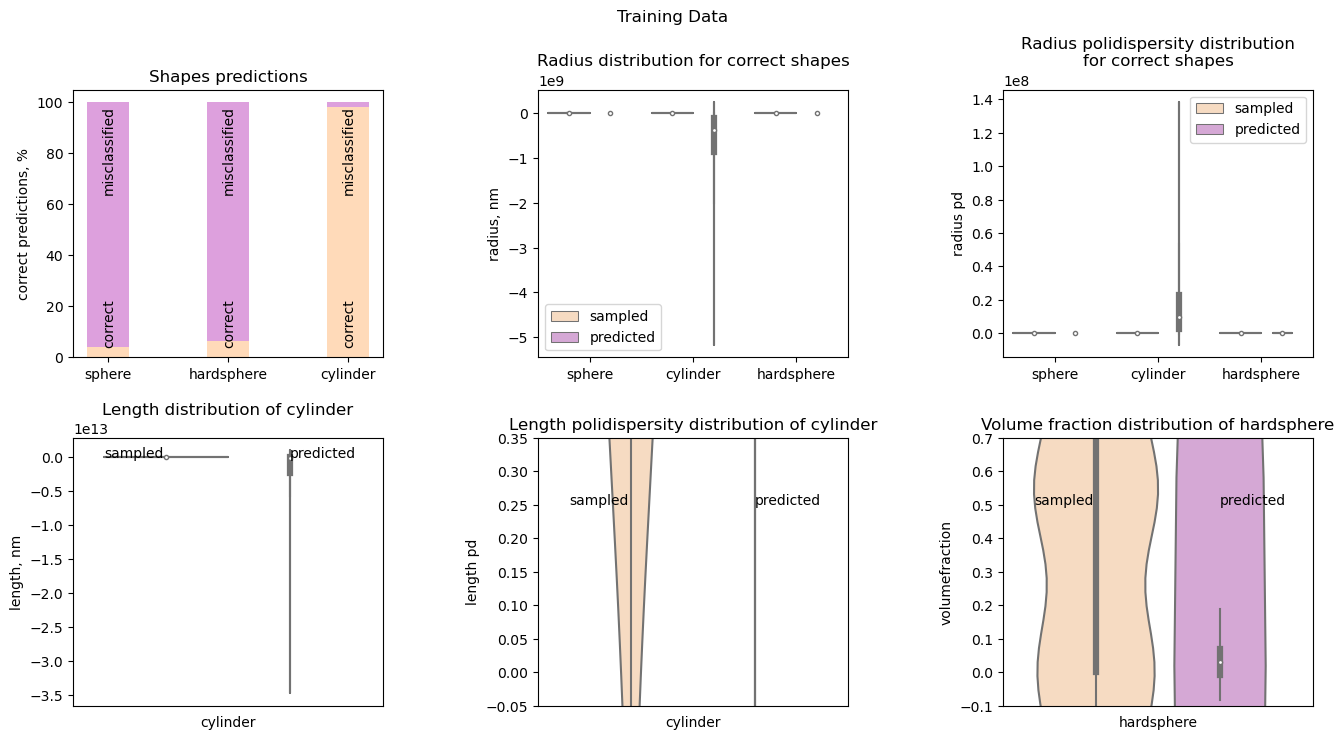

In [181]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 35.67%
MSE for radius per shape for correctly identified instances as follows: sphere: 1763779540.4034, hardsphere: 3725642.6275 and cylinder: 793195683662760960.0000
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 542783.8233, hardsphere: 26.9595 and cylinder: 567404017500575.8750
MSE for cylinder length for correctly identified instances: 37193557622884000193314816.0000
MSE for cylinder length polydispersity for correctly identified instances: 13318598144071370752.0000
MSE for cylinder length for correctly identified instances: 44.6398


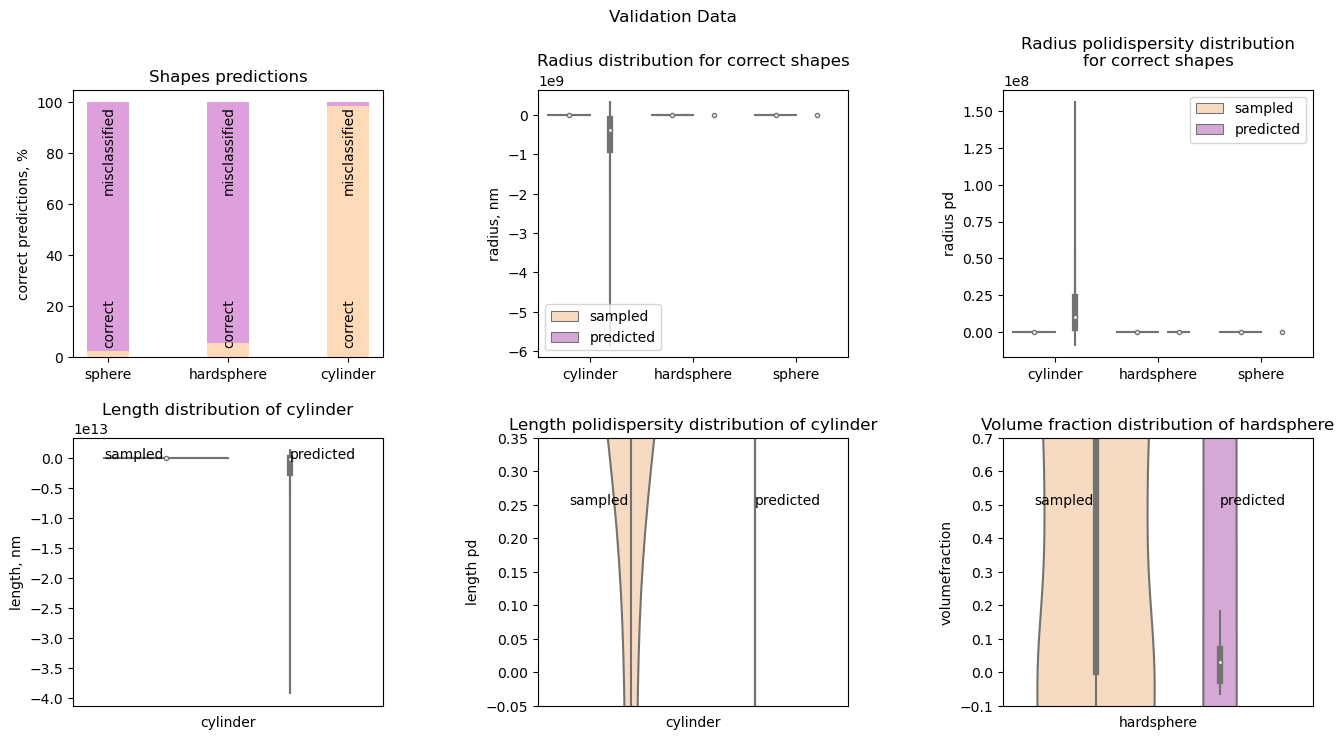

In [182]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 43.47%
MSE for radius per shape for correctly identified instances as follows: sphere: 127649859.4027, hardsphere: 366240098867.8425 and cylinder: 544906418.2896
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 37025.5808, hardsphere: 351176.8960 and cylinder: 36333570.0285
MSE for cylinder length for correctly identified instances: 3213436211312.1489
MSE for cylinder length polydispersity for correctly identified instances: 181213734.9821
MSE for cylinder length for correctly identified instances: 11940776.4888


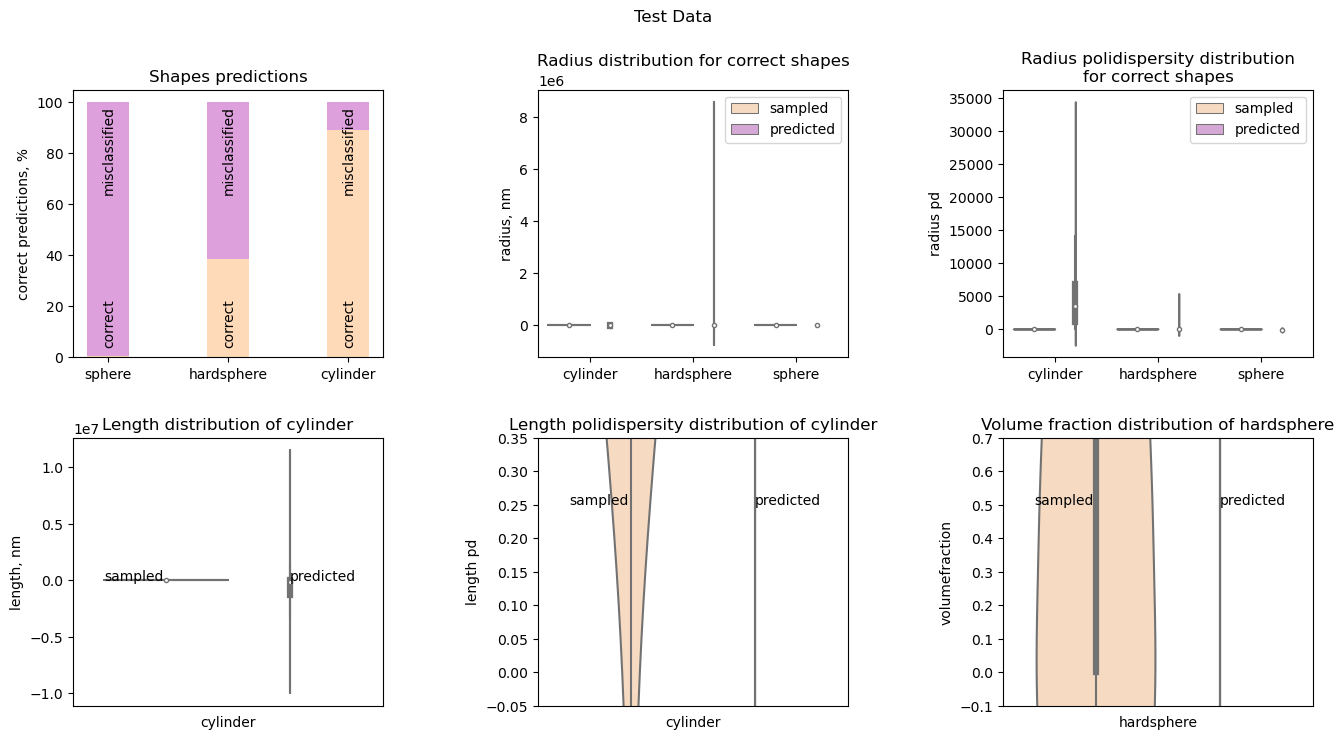

In [172]:
plot_outcomes_identified(df_test, 'Test')